In [26]:
import pandas as pd 
import numpy as np 
%matplotlib inline 

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mkunstler/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [27]:
reviews_full = pd.read_csv('steam_reviews.csv')
len(reviews_full)

434891

Thats a lot of observations, for computational purposes we will limit ourselves to 50k observations which should be plenty enough to produce a descent model.

In [28]:
reviews = reviews_full.sample(50000)

In [29]:
reviews.head()

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title
155631,2015-04-16,0,0,1,False,Not Recommended,A social club account just to play a game ? F ...,Grand Theft Auto V
105047,2018-11-21,0,0,1278,False,Recommended,It's pretty good.,Rocket League®
82862,2017-07-15,0,0,173,False,Recommended,i love this game,Rocket League®
422529,2016-04-29,0,0,46,True,Recommended,1 Buy Rust.2 Install Rust.3 Load rust.4 Spawn ...,Rust
11232,2016-09-03,0,0,109,False,Recommended,This is a really great horror game ever. Just ...,Dead by Daylight


<AxesSubplot:xlabel='title'>

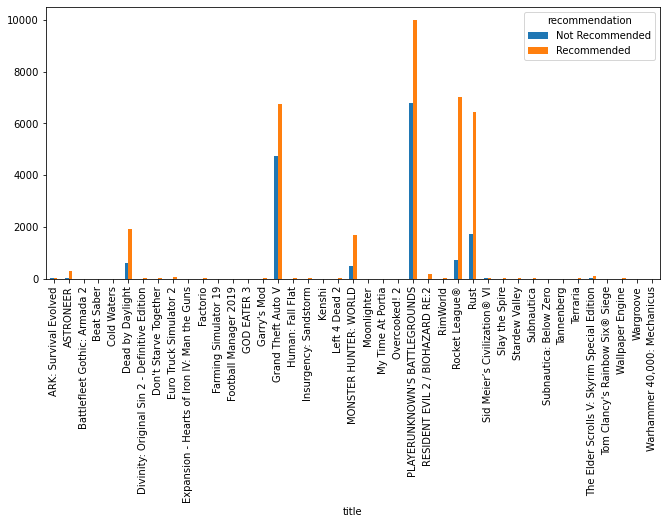

In [30]:
reviews.groupby(['title', 'recommendation']).size().unstack().plot(kind='bar',figsize=(11, 5))

maybe lets also limit ourselves to the 5 most popular games, both for clarity of the resulting plots, and for the model to be more specialized and therefore more reliable.

In [31]:
# extracting the 5 most reviewed games from the dataframe
most_popular_games = reviews.groupby('title').count().sort_values('review').tail(5).index.tolist()

#limiting the dataframe to these games
reviews_orig = reviews.copy()
reviews = reviews.query('title.isin(@most_popular_games)')

<AxesSubplot:xlabel='title'>

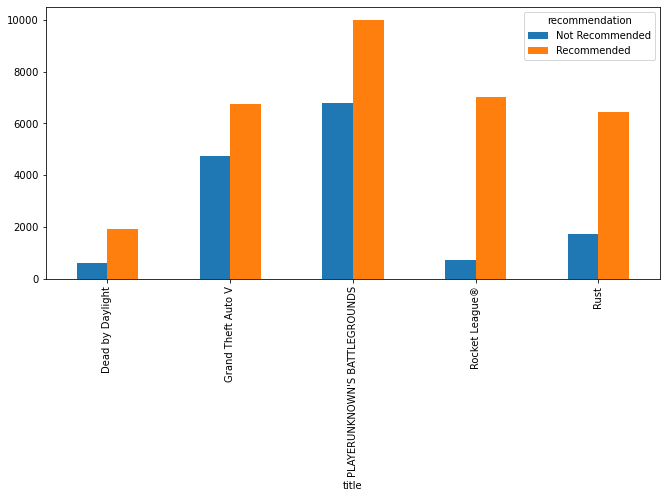

In [33]:
reviews.groupby(['title', 'recommendation']).size().unstack().plot(kind='bar',figsize=(11, 5))

In [34]:
# move to sentiment analysis
def print_sentiment_scores(review):
    snt = analyser.polarity_scores(review)  #call the polarity analyzer
    print("{:-<40} {}".format(review, str(snt)))

In [35]:
# Testing for a popular ironic review formula
print_sentiment_scores("Terrible controlls, unbearable graphics, hate the story, 10/10 would recommend")

Terrible controlls, unbearable graphics, hate the story, 10/10 would recommend {'neg': 0.417, 'neu': 0.429, 'pos': 0.153, 'compound': -0.6486}


As we expected, this is a problem for the model, as the review like this would most likely be positive. To combat this, we will blanketly give every review with a "10/10" in it a positive score.

In [36]:
reviews.loc[reviews['review'].str.match(".*10/10.*", na=False), 'positive_flag'] = 1

reviews["positive_flag"].value_counts()

1.0    2027
Name: positive_flag, dtype: int64

There are 2026 observation with 10/10 in them. Just to further show the utility of such approach, we will also assign a positive score for each review starting with the word "Awsome", no mather if it is in upper or lower case.

In [37]:
reviews.loc[reviews['review'].str.match("[Aa][Ww][Ss][Oo][Mm][Ee].*", na=False), 'positive_flag'] = 1

reviews["positive_flag"].value_counts()

1.0    2071
Name: positive_flag, dtype: int64

there are additional 46 reviews with a positive score assigned. Lets check what is the distribution of the label in these reviews.

In [38]:
reviews.query('positive_flag == 1')['recommendation'].value_counts()

Recommended        1957
Not Recommended     114
Name: recommendation, dtype: int64

In [39]:
1951/2072

0.9416023166023166

In [64]:
reviews["positive_flag"].fillna(0, inplace = True)

Forcing these labels would result in a 94% accuracy for these observations, so it is most likely a good idea to do that. After predicting the label using VADER score we will come back to this flag, to check wether it would imporove or decrease the total accuracy of its prediction.

In [66]:
#removing observations with missing values
print('n obs before removing NAs: ' + str(len(reviews)))
reviews_1 = reviews.dropna()
print('n obs after removing NAs: ' + str(len(reviews_1)))

reviews_1['review'] = reviews_1['review'].apply(lambda review:str(review))

%time # to calulate the time it takes the algorithm to compute a VADER score
i=0 # counter

compval1 = [ ] # empty list to hold our computed 'compound' VADER scores

while (i<len(reviews_1)):

    k = analyser.polarity_scores(reviews_1.iloc[i]['review'])
    compval1.append(k['compound'])
    
    i = i+1
    
# convert sentiment values to numpy for easier usage
compval1 = np.array(compval1)
len(compval1)

n obs before removing NAs: 46686
n obs after removing NAs: 46503
CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 2.62 µs


/var/folders/dc/k7crvlf16t786rmzsdp6xqs00000gn/T/ipykernel_8219/697748449.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_1['review'] = reviews_1['review'].apply(lambda review:str(review))


46503

In [67]:
reviews_1['VADER score'] = compval1

/var/folders/dc/k7crvlf16t786rmzsdp6xqs00000gn/T/ipykernel_8219/1427416955.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_1['VADER score'] = compval1


In [68]:
reviews_1.head(10)

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title,positive_flag,VADER score
155631,2015-04-16,0,0,1,False,Not Recommended,A social club account just to play a game ? F no!! I want my $ back and Rock star can go to hell...,Grand Theft Auto V,0.0,-0.2662
105047,2018-11-21,0,0,1278,False,Recommended,It's pretty good.,Rocket League®,0.0,0.7269
82862,2017-07-15,0,0,173,False,Recommended,i love this game,Rocket League®,0.0,0.6369
422529,2016-04-29,0,0,46,True,Recommended,1 Buy Rust.2 Install Rust.3 Load rust.4 Spawn in server5 Try to familiarise myself with the map ...,Rust,0.0,0.9708
11232,2016-09-03,0,0,109,False,Recommended,This is a really great horror game ever. Just few things that I think the developers need to imp...,Dead by Daylight,0.0,0.5130
137065,2017-02-25,0,0,154,False,Not Recommended,I will start off saying that while this game worked i had a blast playing with my friends in a c...,Grand Theft Auto V,0.0,-0.7433
138382,2017-06-25,0,0,131,False,Not Recommended,game without mods,Grand Theft Auto V,0.0,0.0000
11268,2016-08-06,0,0,199,False,Recommended,I recommend this game to people who are looking for a somewhat new idea to play while keeping a ...,Dead by Daylight,0.0,0.9857
379815,2016-10-08,0,0,23,True,Recommended,This is really COOL but peopel are killing everytime without reason and no one wanna team up so ...,Rust,0.0,0.1393
399703,2018-08-12,0,0,306,False,Recommended,most toxic comunity ive ever seen!,Rust,0.0,0.0000


Since there is no neutral option here, lets make the model predict positive if VADER score > 0 and negative otherwise.

In [69]:
%time

# assign score categories and logic
i = 0

predicted_value = [ ] # empty series to hold our predicted values

while(i<len(reviews_1)):
    if ((reviews_1.iloc[i]['VADER score'] > 0)):
        predicted_value.append('Recommended')
        i = i+1
    else:
        predicted_value.append('Not Recommended')
        i = i+1

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 2.15 µs


In [70]:
reviews_1['predicted sentiment'] = predicted_value

/var/folders/dc/k7crvlf16t786rmzsdp6xqs00000gn/T/ipykernel_8219/2574194438.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_1['predicted sentiment'] = predicted_value


In [71]:
reviews_1.head()

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title,positive_flag,VADER score,predicted sentiment
155631,2015-04-16,0,0,1,False,Not Recommended,A social club account just to play a game ? F no!! I want my $ back and Rock star can go to hell...,Grand Theft Auto V,0.0,-0.2662,Not Recommended
105047,2018-11-21,0,0,1278,False,Recommended,It's pretty good.,Rocket League®,0.0,0.7269,Recommended
82862,2017-07-15,0,0,173,False,Recommended,i love this game,Rocket League®,0.0,0.6369,Recommended
422529,2016-04-29,0,0,46,True,Recommended,1 Buy Rust.2 Install Rust.3 Load rust.4 Spawn in server5 Try to familiarise myself with the map ...,Rust,0.0,0.9708,Recommended
11232,2016-09-03,0,0,109,False,Recommended,This is a really great horror game ever. Just few things that I think the developers need to imp...,Dead by Daylight,0.0,0.5130,Recommended


In [72]:
madeit = reviews_1[reviews_1['recommendation'] == reviews_1['predicted sentiment']]

len(madeit)/len(reviews_1)

0.6983420424488742

<AxesSubplot:xlabel='predicted sentiment'>

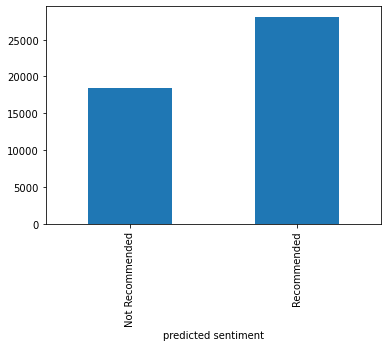

In [73]:
reviews_1.groupby('predicted sentiment').size().plot(kind='bar')

In [74]:
didntmakeit = reviews_1[reviews_1['recommendation'] != reviews_1['predicted sentiment']]

didntmakeit.reset_index(drop=True, inplace=True)
didntmakeit.sort_values('hour_played').tail(10)

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title,positive_flag,VADER score,predicted sentiment
9391,2017-11-22,0,0,5528,False,Recommended,Good game ya there are cheaters but its how you deal with them,Grand Theft Auto V,0.0,0.0000,Not Recommended
1760,2016-07-30,1,1,5551,True,Recommended,Uninstall,Rust,0.0,0.0000,Not Recommended
1450,2017-03-06,0,0,5612,True,Recommended,10/10,Rust,1.0,0.0000,Not Recommended
4509,2017-02-07,0,0,5666,False,Recommended,AYYYYYYYYYYYYYYYYY,Rust,0.0,0.0000,Not Recommended
2198,2016-08-11,2,4,5711,False,Recommended,Actually the best Gta but with a lot of abusing modders which makes it kind of cancerous.,Grand Theft Auto V,0.0,-0.3400,Not Recommended
12431,2017-09-27,1,6,6150,False,Recommended,ㅤㅤㅤㅤ ㅤㅤㅤㅤㅤ ㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤ ㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤ αвσυт ㅤㅤㅤㅤㅤㅤㅤㅤʀᴇᴀʟ ɴᴀᴍᴇ σʟᴇɢ ㅤㅤㅤㅤㅤㅤㅤㅤᴀɢᴇ 18 ㅤ...,PLAYERUNKNOWN'S BATTLEGROUNDS,0.0,0.0000,Not Recommended
13956,2015-07-16,4,3,6789,False,Recommended,This game is crack cocaine use at own risk,Rocket League®,0.0,-0.2732,Not Recommended
7096,2015-02-25,2,3,6834,True,Recommended,Badass Game,Rust,0.0,-0.1531,Not Recommended
12441,2017-02-15,0,0,7443,True,Recommended,Do you want to run at people screaming the most random ever while beating them with a rock? Well...,Rust,0.0,-0.8284,Not Recommended
6843,2014-03-04,0,0,7637,True,Recommended,ppl hacking the official servers no admins very annoyed,Rust,0.0,-0.6240,Not Recommended


Just out of curiosity we have to check what we believe is quite confusing: the reviews of the people with 1000s of hours played that left a negative review.

In [75]:
pd.options.display.max_colwidth = 100
didntmakeit.query('recommendation == "Not Recommended"').sort_values('hour_played').tail(10).iloc[:,[3, 5, 6, 8]]

,hour_played,recommendation,review,positive_flag
7169,3301,Not Recommended,This game blows to many bullies. Filled to the brim with the left overs of the Call of Duty fan ...,0.0
10658,3371,Not Recommended,I played this game for over 2000 Horus. It was until recently one of the best games I have ever ...,0.0
11731,3464,Not Recommended,theres no begining middle or end i played this quit a bit... go out by a rock and bang it on ya ...,0.0
1763,3491,Not Recommended,Unplayable unless you either play with a bounch of people (which simply isnt fun unless you are ...,0.0
8286,3645,Not Recommended,PLease refund the game is,0.0
10614,3685,Not Recommended,Started playing rust when it was early access. Updated first Thursday of every month. This was a...,0.0
12018,3832,Not Recommended,Helk ruined my favorite game. Thanks you piece of,0.0
7814,3847,Not Recommended,Its been a good 2000 hours but i think this game has reached one of its lows. Its ridiculous how...,0.0
12890,3985,Not Recommended,Esports Ready.,0.0
9120,4422,Not Recommended,Having played GTA4 for over 1000 hours and then bought GTA5 I can say that I am left with distas...,0.0


Clearly most of these people are just mad at some changes that the developer made after they played for that long.

Now lets check wether the prediction is improved using the flag constructed using regular expressions.

In [76]:
reviews_1.loc[reviews_1["positive_flag"] == 1, "predicted sentiment"] = 'Recommended'

In [77]:
madeit = reviews_1[reviews_1['recommendation'] == reviews_1['predicted sentiment']]

len(madeit)/len(reviews_1)

0.7161903533105392

Vader scoring got almost 70% of the reviews right, which is not a stellar score concerning that this is binary classification so guessing randomly would get 50% right. The introduction of regular expressions, and through them some expert input into the model increased the accuracy of the model by 2%, which is not a lot, but in a real life scenario it might be very significant. Now, we will attempt to use naive bayes model to tackle this problem, and hope for a better score.

In [20]:
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import movie_reviews

In [21]:
reviews['review'] = reviews['review'].apply(lambda review:str(review))

positive = reviews.query('recommendation == "Recommended"')
negative = reviews.query('recommendation == "Not Recommended"')

In [25]:
def extract_words_pos(row):
    words = row['review'].split()
    word_dict = {word: True for word in words}
    return (word_dict, 'Positive')

features_positive = positive.apply(extract_words_pos, axis=1).tolist()

def extract_words_neg(row):
    words = row['review'].split()
    word_dict = {word: True for word in words}
    return (word_dict, 'Negative')

features_negative = negative.apply(extract_words_neg, axis=1).tolist()

In [26]:
# training and testing datasets
# split the data into train and test (80/20)
threshold_factor = 0.8
threshold_positive = int(threshold_factor * len(features_positive))
threshold_negative = int(threshold_factor * len(features_negative))

In [27]:
# extract the features
features_train = features_positive[:threshold_positive] + features_negative[:threshold_negative]
features_test = features_positive[threshold_positive:] + features_negative[threshold_negative:]  
print("\nNumber of training datapoints:" , len(features_train))
print("Number of test datapoints:" , len(features_test))


Number of training datapoints: 37423
Number of test datapoints: 9357


In [28]:
# train a Naive Bayes classifier
classifier = NaiveBayesClassifier.train(features_train)
print("\nAccuracy of the classifier:", nltk.classify.util.accuracy(classifier, features_test))


Accuracy of the classifier: 0.5833066153681735


In [29]:
print("\nTop 10 most informative words:")
for item in classifier.most_informative_features()[:10]:
    print (item[0])


Top 10 most informative words:
behalf
Two.
Garbage
cheated
protest
milking
Platform
behaviors
TRASH
OpenIV.


Its hard to tell why some of them are so informative, for example the word "behalf" doesn't have any positive or negative connotation to our knowledge, however words such as "Garbage" and "TRASH" do have a strong negative connotation so we might have expected to see them.

The model performs even worse than VADER based approach, so maybe this dataset is not very well explainable. This might be the case because the people contributing have no cost for leaving a review, so they can say whatever they want, even if it is gibberish.